In [1]:
import ccxt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math
from datetime import datetime
from sklearn.linear_model import LinearRegression
bnc = ccxt.binance()

In [132]:
def load_crypto_batch(since,timeframe,symbols):
    bnc = ccxt.binance()
    dataframes = []
    labels = []
    for coin in symbols:
        pair = "".join([coin,"/USDT"])
        try:
            dataframes.append(pd.DataFrame(bnc.fetch_ohlcv(pair,limit=1000,since=since,timeframe=timeframe),columns=["timestamp","open","high","low","close","volume"]).set_index("timestamp"))
            labels.append(str(coin))
        except:
            print("Binance does not have", coin)
    coinFrames = pd.DataFrame(dataframes[0][["close","volume"]]).rename(columns={'close':"".join(['BTC_',"CLOSE"]),'volume':"".join(['BTC_',"VOL"])})
    for i,coin in enumerate(labels[1:]):
        temp_frame = pd.DataFrame(dataframes[i+1]["close","volume"]).rename(columns={'close':"".join(coin,"CLOSE"),'volume':"".join(coin,"VOL")})
        coinFrames = coinFrames.merge(temp_opens,how='outer',on='timestamp')
    return (coinFrames)

def load_crypto(days=1000,n=30,timeframe='1h'):
    bnc = ccxt.binance()
    #symbols = ['BTC','ETH','BNB','SOL','ADA','XRP','DOT','DOGE','SHIB','LUNA','AVAX','UNI','LINK','LTC','MATIC','ALGO','BCH','VET','AXS','XLM','ATOM','ICP','FIL','THETA','TRX']
    symbols = ['BTC']
    n = min(len(symbols),n)
    symbols = symbols[:n]
    since = bnc.milliseconds () - 86400000*days  # -1*days day from now
    all_orders = []
    while since <= (bnc.milliseconds()-2000*60*60*24):
        limit = 1000  # change for your limit
        orders = load_crypto_batch(since,timeframe,symbols)
        since = int(orders.index[-1])
        all_orders.append(orders)
        print(bnc.milliseconds()/1000,pd.to_datetime(since,unit='ms'))
    combined = pd.concat(all_orders)
    return combined
    
#gets a dataframe of prices, returns a dataframe of returns
def get_returns(prices: object) -> object:
    price_arr = np.asarray(prices)
    time_arr = np.asarray(prices.index)
    columns = np.asarray(prices.columns)
    returns = np.zeros([len(time_arr)-1,len(columns)])
    for i,val in enumerate(time_arr[1:]):
        returns[i] = price_arr[i+1,:]/price_arr[i,:]
    returns_df = pd.DataFrame(returns,index=time_arr[1:], columns=columns)
    return pd.DataFrame(returns_df)

#gets a dataframe of prices, returns a dataframe of the log returns
def get_log_returns(prices: object) -> object:
    price_arr = np.asarray(prices)
    time_arr = np.asarray(prices.index)
    columns = np.asarray(prices.columns)
    log_returns = np.zeros([len(time_arr)-1,len(columns)])
    for i,val in enumerate(time_arr[1:]):
        log_returns[i] = np.log(price_arr[i+1,:]/price_arr[i,:])
    log_returns_df = pd.DataFrame(log_returns,index=time_arr[1:], columns=columns)
    return pd.DataFrame(log_returns_df)

def proc_ccxt_timestamps(df: object) -> object:
    df.index = pd.to_datetime(df.index,unit='ms')
    return df


In [3]:
#loads and writes the data to csv
#opens=load_crypto(days=1500,timeframe='1d')
#opens.to_csv('BitcoinData')

In [130]:
#loads bitcoin price and volume data and creates appropriate vectors
df = pd.read_csv('BTC_data').set_index("timestamp")
df = proc_ccxt_timestamps(df.dropna(axis=0))

#loads number of bitcoins and processes timestamps
numcoins = pd.read_csv('BTC_numcoins.csv').set_index("Timestamp")
numcoins.index = numcoins.index.rename('timestamp')
numcoins.index = pd.to_datetime(numcoins.index)
numcoins.index = numcoins.index.round('D')

#merges with price data
df = df.merge(numcoins,how='left',on='timestamp')
df = df.fillna(method='bfill')
df['pct_cap'] = df.BTC_VOL/df["total-bitcoins"]

#loads SP500 data
sp = pd.read_csv('SP500_data.csv').set_index("Date")
sp.index = sp.index.rename('timestamp')
sp.index = pd.to_datetime(sp.index)
sp.index = sp.index.round('D')

#merge on btc table
sp = df.merge(sp,how='left',on='timestamp')
sp.Volume = sp.Volume.fillna(0) #fills empty volumes with 0, not bfill
sp = sp.fillna(method='bfill')
sp = sp.fillna(method='ffill')
sp.Close = pd.to_numeric(sp.Close)
sp.Volume = pd.to_numeric(sp.Volume)
sp["Market_Cap"] = sp.Close*8.6e9
sp["pct"] = sp.Volume/sp.Market_Cap

In [248]:
btc_returns = get_returns(pd.DataFrame(df.BTC_CLOSE)).BTC_CLOSE.values
btc_logr = get_log_returns(pd.DataFrame(df.BTC_CLOSE)).BTC_CLOSE.values
btc_lrsq = ((btc_logr)**2)
btc_vol = df.BTC_VOL.iloc[1:].values
btc_pct = df.pct_cap[1:].values
btc_r_pct = np.nan_to_num((btc_returns-1)/btc_pct)
btc_lrsq_pct = np.nan_to_num(btc_lrsq/btc_pct)

sp_returns = get_returns(pd.DataFrame(sp.Close)).Close.values
sp_logr = get_log_returns(pd.DataFrame(sp.Close)).Close.values
sp_lrsq = ((sp_logr)**2)
sp_vol = sp.Volume.iloc[1:].values
sp_pct = sp.pct[1:].values
sp_r_pct = np.nan_to_num((sp_returns-1)/sp_pct)
sp_lrsq_pct = np.nan_to_num(sp_lrsq/sp_pct)

<ipython-input-248-dd9d81eb89a5>:14: RuntimeWarning: divide by zero encountered in true_divide
  sp_r_pct = np.nan_to_num((sp_returns-1)/sp_pct)
<ipython-input-248-dd9d81eb89a5>:14: RuntimeWarning: invalid value encountered in true_divide
  sp_r_pct = np.nan_to_num((sp_returns-1)/sp_pct)
<ipython-input-248-dd9d81eb89a5>:15: RuntimeWarning: divide by zero encountered in true_divide
  sp_lrsq_pct = np.nan_to_num(sp_lrsq/sp_pct)
<ipython-input-248-dd9d81eb89a5>:15: RuntimeWarning: invalid value encountered in true_divide
  sp_lrsq_pct = np.nan_to_num(sp_lrsq/sp_pct)


<ipython-input-253-6b86b29f1046>:2: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(sp.index[1:],sp_lrsq/sp_pct,alpha=.5)
<ipython-input-253-6b86b29f1046>:2: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(sp.index[1:],sp_lrsq/sp_pct,alpha=.5)


(0.0, 25.0)

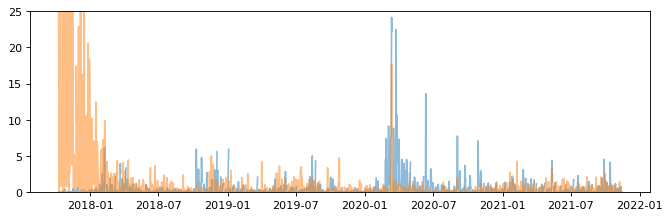

In [253]:
figure(figsize=(10, 3), dpi=80)
plt.plot(sp.index[1:],sp_lrsq/sp_pct,alpha=.5)
plt.plot(sp.index[1:],btc_lrsq/btc_pct,alpha=.5)
plt.ylim((0,25))

1


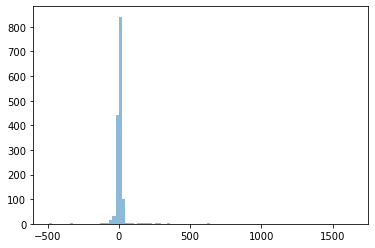

In [251]:
plt.hist(btc_r_pct,bins=100,alpha=.5)
#plt.hist(sp_r_pct,bins=100,alpha=.5)
print("1")

IndexError: index -9223372036854775808 is out of bounds for axis 0 with size 101

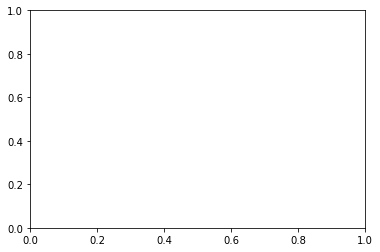

In [252]:
plt.hist(sp_r_pct,bins=100,alpha=.5)